## Dimensionality Reduction: LDA vs PCA

**LDA** is a supervised dimensionality reduction technique whose goal is to find a linear combination of features that best separates two or more classes. Unlike **PCA**, which is an unsupervised technique that finds directions (principal components) of maximum variance in the data without considering class labels, LDA takes class information into account. This makes LDA more suitable when the target variable (class label) is known and we are interested in separating categories.


**Example Dataset: Student Gender and Subject Scores**

Let’s take a simple dataset of students with their gender and their scores in two subjects: Math and English.

| Student | Gender | Math Score | English Score |
| ------- | ------ | ---------- | ------------- |
| A       | Male   | 80         | 65            |
| B       | Male   | 85         | 70            |
| C       | Male   | 78         | 60            |
| D       | Female | 60         | 85            |
| E       | Female | 62         | 80            |
| F       | Female | 65         | 88            |

This dataset has: 2 numerical features: Math Score and English Score and 1 class label: Gender (Male or Female).

##### Applying PCA

In PCA, we ignore the Gender information. We simply analyze the variation across the two features: Math and English scores.

* PCA will compute directions (called principal components) that explain the maximum variance in the data.
* The first principal component might capture the direction where both scores vary the most jointly (say, a diagonal direction in the Math-English plane).
* The second component will be orthogonal to the first and will capture the remaining variance.

However, PCA doesn’t aim to separate males from females. So, if both male and female students have overlapping distributions along the direction of highest variance, PCA will not help us distinguish them effectively.


##### Applying LDA

In LDA, the Gender class label is used. The goal is to find a new axis (called a linear discriminant) that best separates males from females based on Math and English scores.

Let's revisit the steps again:

1. Compute the overall mean of each feature.
2. Compute the class means (mean Math and English scores for males and for females).
3. Calculate within-class scatter (how much variance is there within each class).
4. Calculate between-class scatter (how different the class means are from each other).
5. Solve an optimization problem to find a direction that maximizes between-class variance and minimizes within-class variance.

This new direction is the linear discriminant. When we project the original 2D data onto this 1D line:

* Males and females will ideally form two distinct clusters.
* This helps in classification and visualization.

Since we have two classes (C = 2), LDA will produce at most 1 linear discriminant (C - 1 = 1).

## Python Code Implementation

In [2]:
# Importing all the necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import time

In [3]:
# Loading the dataset

data = pd.read_csv('winequality.csv')
df = data.copy()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
# There are no Null values and we can move to Standardization

scaler = StandardScaler()

X = df.iloc[:,0:11].values
y = df.iloc[:,11].values  # last Column is the Target

X_std = scaler.fit_transform(X)

In [8]:
df.iloc[:,11].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

### LDA Operations

#### Calculating class mean

In [10]:
np.set_printoptions(precision=1)

mean_vectors=[]
for gr in range(3,9):  # As the class label starts from 3 to 8
    mean_vectors.append(np.mean(X_std[y==gr],axis=0))
    print('Mean Vector quality %s :%s\n'%(gr,mean_vectors[gr-3]))

Mean Vector quality 3 :[ 0.   2.  -0.5  0.1  0.7 -0.5 -0.7  0.4  0.6 -0.5 -0.4]

Mean Vector quality 4 :[-0.3  0.9 -0.5  0.1  0.1 -0.3 -0.3 -0.1  0.5 -0.4 -0.1]

Mean Vector quality 5 :[-0.1  0.3 -0.1 -0.   0.1  0.1  0.3  0.2 -0.  -0.2 -0.5]

Mean Vector quality 6 :[ 0.  -0.2  0.  -0.  -0.1 -0.  -0.2 -0.1  0.   0.1  0.2]

Mean Vector quality 7 :[ 0.3 -0.7  0.5  0.1 -0.2 -0.2 -0.3 -0.3 -0.1  0.5  1. ]

Mean Vector quality 8 :[ 0.1 -0.6  0.6  0.  -0.4 -0.2 -0.4 -0.8 -0.3  0.6  1.6]



#### Calculating Within Class Matrix

In [11]:
S_w = np.zeros((11,11))

for gr,mv in zip(range(3,9), mean_vectors):
    class_sc_mat=np.zeros((11,11))
    
    for row in X_std[y==gr]:
        
        row,mv = row.reshape(11,1), mv.reshape(11,1)
        class_sc_mat+=(row-mv).dot((row-mv).T)

    S_w+=class_sc_mat
print('Within class-scatter matrix:\n',S_w)

Within class-scatter matrix:
 [[ 1.6e+03 -3.3e+02  1.0e+03  1.8e+02  1.7e+02 -2.3e+02 -1.4e+02  1.1e+03
  -1.1e+03  2.4e+02 -2.0e+02]
 [-3.3e+02  1.3e+03 -7.4e+02  1.1e+01  1.7e+01 -3.9e+01  2.3e+01 -6.5e+01
   3.3e+02 -2.6e+02 -4.3e+01]
 [ 1.0e+03 -7.4e+02  1.5e+03  2.2e+02  3.7e+02 -7.7e+01  1.2e+02  6.5e+02
  -8.4e+02  4.1e+02 -7.7e-01]
 [ 1.8e+02  1.1e+01  2.2e+02  1.6e+03  9.3e+01  3.1e+02  3.3e+02  5.8e+02
  -1.4e+02  1.9e-01  4.6e+01]
 [ 1.7e+02  1.7e+01  3.7e+02  9.3e+01  1.6e+03 -4.9e+00  3.4e+01  2.8e+02
  -4.3e+02  6.5e+02 -2.5e+02]
 [-2.3e+02 -3.9e+01 -7.7e+01  3.1e+02 -4.9e+00  1.6e+03  1.0e+03 -6.5e+01
   1.2e+02  1.1e+02 -3.7e+01]
 [-1.4e+02  2.3e+01  1.2e+02  3.3e+02  3.4e+01  1.0e+03  1.5e+03  3.8e+01
  -9.3e+01  1.5e+02 -1.3e+02]
 [ 1.1e+03 -6.5e+01  6.5e+02  5.8e+02  2.8e+02 -6.5e+01  3.8e+01  1.5e+03
  -5.5e+02  3.1e+02 -6.3e+02]
 [-1.1e+03  3.3e+02 -8.4e+02 -1.4e+02 -4.3e+02  1.2e+02 -9.3e+01 -5.5e+02
   1.6e+03 -3.0e+02  3.5e+02]
 [ 2.4e+02 -2.6e+02  4.1e+02  1.9e

#### Calculating Between Class Matrix

In [12]:
overall_mean = np.mean(X_std, axis=0)
c=0
S_b=np.zeros((11,11))
for i, mean_vec in enumerate(mean_vectors):
    n=X_std[y==i+3,:].shape[0]
    c+=1
    mean_vec=mean_vec.reshape(11,1)
    overall_mean=overall_mean.reshape(11,1)
    S_b+=n*(mean_vec-overall_mean).dot((mean_vec-overall_mean).T)
  
print('Between class scatter matrix:\n',S_b)

Between class scatter matrix:
 [[  30.9  -78.1   52.     6.4  -23.8  -12.6  -38.   -33.7  -13.6   52.6
    99.5]
 [ -78.1  256.6 -142.7   -7.9   81.    22.    99.4  100.7   42.5 -154.7
  -280.3]
 [  52.  -142.7   93.1   11.   -45.9  -20.2  -60.6  -63.1  -27.9   93.6
   176.5]
 [   6.4   -7.9   11.     5.3   -4.3   -7.    -8.1   -8.5   -1.5    8.7
    21.7]
 [ -23.8   81.   -45.9   -4.3   29.7   13.8   42.    40.8    9.4  -52.6
  -104.3]
 [ -12.6   22.   -20.2   -7.    13.8   23.5   46.4   30.1   -8.4  -27.7
   -73.7]
 [ -38.    99.4  -60.6   -8.1   42.    46.4  118.4   75.6  -13.2  -85.8
  -196.9]
 [ -33.7  100.7  -63.1   -8.5   40.8   30.1   75.6   64.5    5.5  -75.4
  -162. ]
 [ -13.6   42.5  -27.9   -1.5    9.4   -8.4  -13.2    5.5   21.5  -19.
   -20.8]
 [  52.6 -154.7   93.6    8.7  -52.6  -27.7  -85.8  -75.4  -19.   104.5
   204.9]
 [  99.5 -280.3  176.5   21.7 -104.3  -73.7 -196.9 -162.   -20.8  204.9
   426.4]]


#### Finding the Eigen Values and Eigen Vectors

In [14]:
eig_vals,eig_vecs=np.linalg.eig(np.linalg.inv(S_w).dot(S_b))

for i in range(len(eig_vals)):
    eigvec_sc=eig_vecs[:,i].reshape(11,1)
    print('\nEigenvector {}:\n{}'.format(i+1,eigvec_sc.real))
    print('\nEigenvalue {:}:{:.2e}'.format(i+1,eig_vals[i].real))


Eigenvector 1:
[[ 0.2]
 [-0.4]
 [-0. ]
 [ 0.1]
 [-0.2]
 [ 0.1]
 [-0.3]
 [-0.2]
 [-0. ]
 [ 0.4]
 [ 0.7]]

Eigenvalue 1:6.32e-01

Eigenvector 2:
[[-0.5]
 [-0.5]
 [-0.2]
 [-0.2]
 [-0.1]
 [ 0. ]
 [ 0.3]
 [ 0.5]
 [-0.4]
 [-0.1]
 [ 0.1]]

Eigenvalue 2:7.64e-02

Eigenvector 3:
[[ 0.1]
 [ 0.3]
 [ 0.4]
 [ 0.2]
 [-0.1]
 [-0.4]
 [ 0.5]
 [-0.5]
 [-0.1]
 [ 0.1]
 [-0.1]]

Eigenvalue 3:2.48e-02

Eigenvector 4:
[[ 0.7]
 [-0.2]
 [-0.1]
 [ 0.2]
 [ 0.1]
 [-0.1]
 [ 0.1]
 [-0.4]
 [ 0.4]
 [-0. ]
 [-0.3]]

Eigenvalue 4:6.43e-03

Eigenvector 5:
[[-0.2]
 [ 0.3]
 [ 0.3]
 [-0.4]
 [ 0.2]
 [ 0.4]
 [-0.2]
 [ 0.5]
 [-0.2]
 [-0.1]
 [ 0.4]]

Eigenvalue 5:4.18e-03

Eigenvector 6:
[[ 0.1]
 [ 0.2]
 [ 0.2]
 [ 0.1]
 [-0.5]
 [ 0.2]
 [-0.3]
 [-0.1]
 [-0. ]
 [ 0.4]
 [-0.4]]

Eigenvalue 6:5.08e-17

Eigenvector 7:
[[ 0.1]
 [ 0.2]
 [ 0.2]
 [ 0.1]
 [-0.5]
 [ 0.2]
 [-0.3]
 [-0.1]
 [-0. ]
 [ 0.4]
 [-0.4]]

Eigenvalue 7:5.08e-17

Eigenvector 8:
[[-0.7]
 [-0.1]
 [ 0.1]
 [ 0.2]
 [ 0.4]
 [-0.2]
 [-0.1]
 [ 0.3]
 [-0.2]
 [ 0.3]
 [-0. ]]

#### Order the eigenpairs in descending order with respect to the eigenvalues

In [15]:
eig_pairs=[]
for i in range(len(eig_vals)):
    if eig_vals[i]<0:
        eig_pairs.append((-eig_vals[i],-eig_vecs[:,i]))
    else:
        eig_pairs.append((eig_vals[i],eig_vecs[:,i]))
eig_pairs=sorted(eig_pairs,key=lambda k: k[0], reverse=True)

print('Evalues in decreasing order:\n')
for i in range(len(eig_pairs)):
    print('Evalue:\n')
    print(eig_pairs[i][0].real)
    print('\n')
    print('Associated evector:\n')
    print(eig_pairs[i][1].real)
    print('\n')

Evalues in decreasing order:

Evalue:

0.6318983806659397


Associated evector:

[ 0.2 -0.4 -0.   0.1 -0.2  0.1 -0.3 -0.2 -0.   0.4  0.7]


Evalue:

0.0764403871234221


Associated evector:

[-0.5 -0.5 -0.2 -0.2 -0.1  0.   0.3  0.5 -0.4 -0.1  0.1]


Evalue:

0.024797465211396048


Associated evector:

[ 0.1  0.3  0.4  0.2 -0.1 -0.4  0.5 -0.5 -0.1  0.1 -0.1]


Evalue:

0.006428277646001722


Associated evector:

[ 0.7 -0.2 -0.1  0.2  0.1 -0.1  0.1 -0.4  0.4 -0.  -0.3]


Evalue:

0.00417995914504446


Associated evector:

[-0.2  0.3  0.3 -0.4  0.2  0.4 -0.2  0.5 -0.2 -0.1  0.4]


Evalue:

5.0814854795788454e-17


Associated evector:

[ 0.1  0.2  0.2  0.1 -0.5  0.2 -0.3 -0.1 -0.   0.4 -0.4]


Evalue:

5.0814854795788454e-17


Associated evector:

[ 0.1  0.2  0.2  0.1 -0.5  0.2 -0.3 -0.1 -0.   0.4 -0.4]


Evalue:

1.537002302154073e-17


Associated evector:

[ 0.7  0.1 -0.1 -0.2 -0.4  0.2  0.1 -0.3  0.2 -0.3  0. ]


Evalue:

1.1691602543996561e-17


Associated evector:

[ 0.7  0.1 -0.3 -0.

#### Explained variance by each respective eigenvector

In [16]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0].real/eigv_sum.real)))  

Variance explained:

eigenvalue 1: 84.96%
eigenvalue 2: 10.28%
eigenvalue 3: 3.33%
eigenvalue 4: 0.86%
eigenvalue 5: 0.56%
eigenvalue 6: 0.00%
eigenvalue 7: 0.00%
eigenvalue 8: 0.00%
eigenvalue 9: 0.00%
eigenvalue 10: 0.00%
eigenvalue 11: 0.00%


In [17]:
# Take the first two eigenvectors retaining the most variance

W = np.hstack((eig_pairs[0][1].reshape(11,1), eig_pairs[1][1].reshape(11,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.2 -0.5]
 [-0.4 -0.5]
 [-0.  -0.2]
 [ 0.1 -0.2]
 [-0.2 -0.1]
 [ 0.1  0. ]
 [-0.3  0.3]
 [-0.2  0.5]
 [-0.  -0.4]
 [ 0.4 -0.1]
 [ 0.7  0.1]]


#### Project the data onto the new axes (linear discriminants)

In [18]:
X_lda = X_std.dot(W)

X_std.shape, X_lda.shape

((1599, 11), (1599, 2))

#### Comparing using LDA from sklearn

In [22]:
lda = LDA()
X_using_lda = lda.fit_transform(X_std, y)

In [24]:
lda.explained_variance_ratio_

array([0.8, 0.1, 0. , 0. , 0. ])

We see 2 components here that is enough to have and this is the same as we got performing LDA from scratch

In [25]:
lda = LDA(n_components=2)
X_using_lda = lda.fit_transform(X_std, y)

X_using_lda.shape

(1599, 2)

### Plotting Dataset

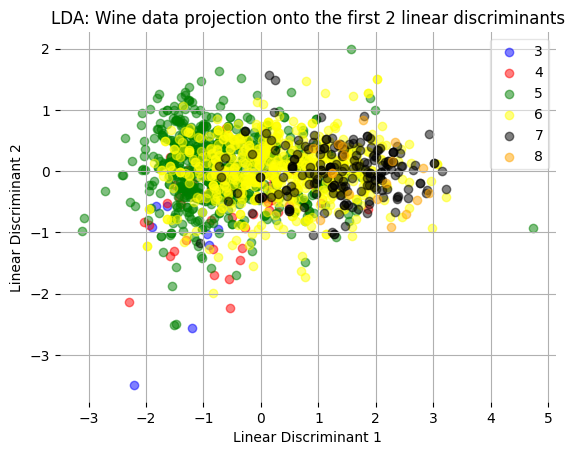

In [19]:
def plot_step_lda():
    fig=plt.figure()
    
    ax = plt.subplot(111)
    
    for label,color in zip(
        range(3,9),('blue', 'red', 'green','yellow','black','orange')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                
               color=color,
                alpha=0.5,
                label=label
               )
       
    plt.xlabel('Linear Discriminant 1')
    plt.ylabel('Linear Discriminant 2')
    
    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Wine data projection onto the first 2 linear discriminants')
 
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.show()

plot_step_lda()

### Using PCA

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

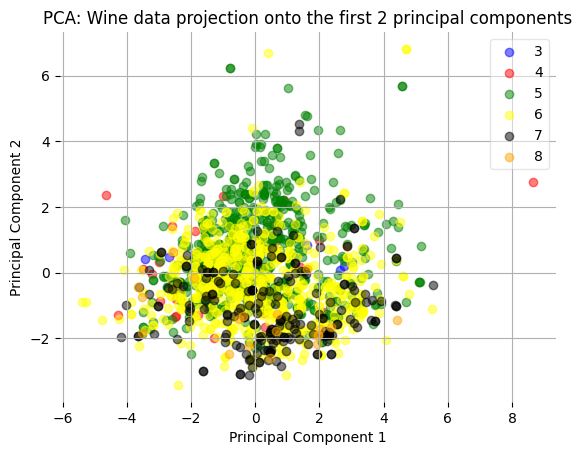

In [21]:
def plot_step_pca():
    fig=plt.figure()

    ax = plt.subplot(111)
    for label,color in zip(
            range(3,9),('blue', 'red', 'green','yellow','black','orange')):

            plt.scatter(x=X_pca[:,0].real[y == label],
                    y=X_pca[:,1].real[y == label],
                
                    color=color,
                    alpha=0.5,
                    label=label
                    )

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title("PCA: Wine data projection onto the first 2 principal components")
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.show() 
plot_step_pca()

## Let's Train Model using LDA and PCA

In [26]:
data = pd.read_csv('winequality.csv')
df = data.copy()

X = df.iloc[:,0:11].values
y = df.iloc[:,11].values 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# Performing LDA

lda = LDA(n_components=2)
X_train_lda=lda.fit_transform(X_train,y_train)
X_test_lda=lda.transform(X_test)

In [28]:
# Performing PCA

pca = PCA(n_components=2)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)

In [29]:
# Initiating Model

svclassifier = SVC(kernel='linear')

In [30]:
# Running the model with LDA

def train_test_lda():
    s=[]
    start_train_lda=time.time()
    svclassifier.fit(X_train_lda,y_train)
    finish_train_lda=time.time()
    
    start_test_lda=time.time()
    y_pred_lda=svclassifier.predict(X_test_lda)
    finish_test_lda=time.time()
  
    s.append(finish_train_lda-start_train_lda)
    s.append(finish_test_lda-start_test_lda)
    s.append(y_pred_lda)

    return s

In [31]:
# Running the model with PCA

def train_test_pca():
    l=[]
    start_train_pca=time.time()
    svclassifier.fit(X_train_pca,y_train)
    finish_train_pca=time.time()
    
    start_test_pca=time.time()
    y_pred_pca=svclassifier.predict(X_test_pca)
    finish_test_pca=time.time()
  
    l.append(finish_train_pca-start_train_pca)
    l.append(finish_test_pca-start_test_pca)
    l.append(y_pred_pca)
    
    return l

Analysis of the Training and Testing Times for the Classifier and Its Accuracy

In [32]:
train_pca=0
test_pca=0
for i in range(10):
    
    m=train_test_pca()
    train_pca+=m[0]
    test_pca+=m[1]
    
print('Average time for training out of 10 runs for PCA:{}'.format(train_pca/10))
print('Average time for testing out of 10 runs for PCA:{}'.format(test_pca/10))

Average time for training out of 10 runs for PCA:0.06221835613250733
Average time for testing out of 10 runs for PCA:0.00895535945892334


In [33]:
a = train_test_lda()
b = train_test_pca()

In [34]:
cm_lda = confusion_matrix(y_test,a[2])
print('Confussion matrix for LDA:\n')
print(cm_lda)
print('\n')
print('LDA Accuracy:'+' '+ str(accuracy_score(y_test,a[2])))

Confussion matrix for LDA:

[[  0   0   2   0   0   0]
 [  0   0   6   5   0   0]
 [  0   0 107  28   0   0]
 [  0   0  45  97   0   0]
 [  0   0   1  26   0   0]
 [  0   0   0   3   0   0]]


LDA Accuracy: 0.6375


In [35]:
cm_pca = confusion_matrix(y_test,b[2])
print('Confussion matrix for PCA:\n')
print(cm_pca)
print('\n')
print('PCA Accuracy:'+' '+ str(accuracy_score(y_test,b[2])))

Confussion matrix for PCA:

[[ 0  0  0  2  0  0]
 [ 0  0  4  7  0  0]
 [ 0  0 87 48  0  0]
 [ 0  0 54 88  0  0]
 [ 0  0  4 23  0  0]
 [ 0  0  0  3  0  0]]


PCA Accuracy: 0.546875
